### Setup

In [19]:
import json

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from scipy.spatial import ConvexHull
import darkdetect
import contextily as cx
from shapely.geometry import Point

if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

region_id = 'rudy'
# region_id = 'pilchowice'
# region_id = 'rudnik'

### Loading data

In [20]:
with open(f'../generated/{region_id}/data.json') as f:
    data = json.load(f)

places: list[tuple[str, float, float]] = []
for section in data['sections']:
    for place in section['places']:
        places.append((place['id'], place['lng'], place['lat']))

coords = np.array([(lng, lat) for _, lng, lat in places])
hull = ConvexHull(coords)
center = coords.mean(0)

print(f'center: lng={center[0]}, lat={center[1]}')

center: lng=18.411157184210527, lat=50.20463661842104


### Printing coordinates of places most far away

In [21]:
bounding_indices = np.unique(hull.simplices.flat)

bounding_places = [places[i] for i in bounding_indices]
for i, place in enumerate(bounding_places):
    print(f'vertex {i}, {place[0]}, {place[1]}, {place[2]}')

vertex 0, osrodek_wodnik, 18.3055, 50.19439
vertex 1, arentowka, 18.327444, 50.25594
vertex 2, groby_strazakow, 18.316975, 50.227043
vertex 3, kapliczka_huberta, 18.395882, 50.154343
vertex 4, lesny_przystanek, 18.48603, 50.17679
vertex 5, lipki, 18.486639, 50.195473
vertex 6, orly, 18.450594, 50.23557
vertex 7, magdalenka, 18.416035, 50.25965


### Chart

(6471048.359599436, 6493364.667716604)

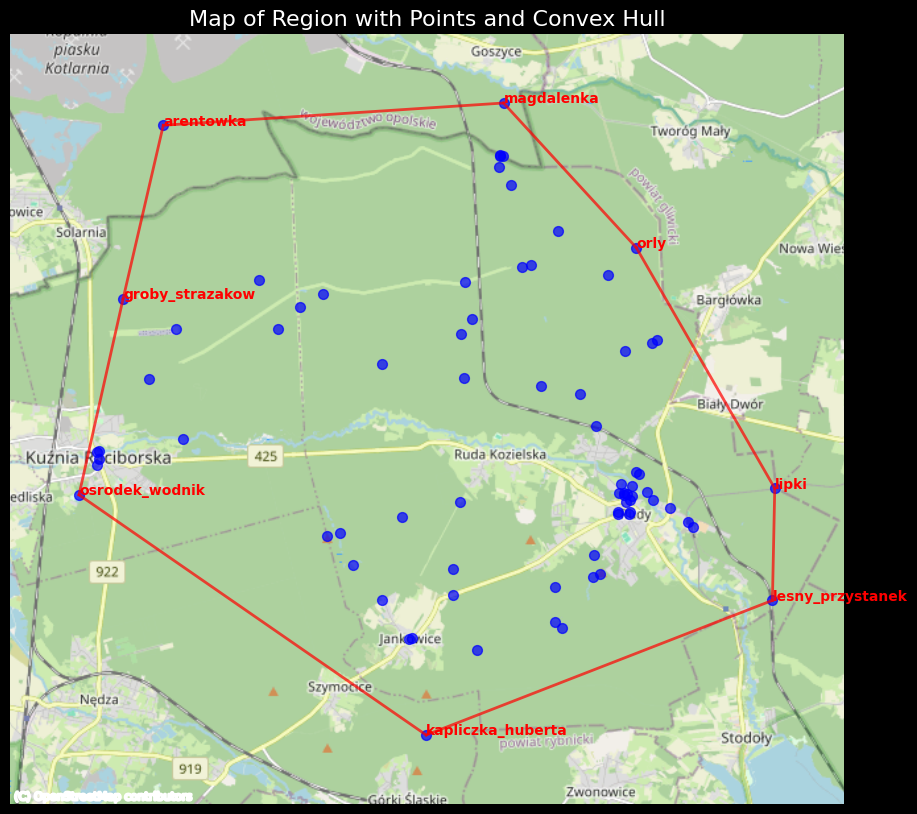

In [23]:
bounding_coords = np.array([(place[1], place[2]) for place in bounding_places])
lngs = np.take(bounding_coords, 0, axis=1)
lats = np.take(bounding_coords, 1, axis=1)
for_plot = np.vstack([lngs, lats])
points = np.array(coords)

# Create a GeoDataFrame from the points
geometry = [Point(lng, lat) for lng, lat in coords]
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Create a figure with a larger size for better visibility
fig, ax = plt.subplots(figsize=(12, 10))

# Convert to Web Mercator projection for compatibility with web map tiles
gdf = gdf.to_crs(epsg=3857)

# Plot the GeoDataFrame
gdf.plot(ax=ax, color='blue', markersize=50, alpha=0.7)

# Add the convex hull lines
for i, simplex in enumerate(hull.simplices):
    # Get the coordinates for this simplex
    lng_points = points[simplex, 0]
    lat_points = points[simplex, 1]

    # Convert to Web Mercator for plotting
    points_gdf = gpd.GeoDataFrame(
        geometry=[Point(lng, lat) for lng, lat in zip(lng_points, lat_points)],
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Extract the transformed coordinates
    x_coords = points_gdf.geometry.x.values
    y_coords = points_gdf.geometry.y.values

    # Plot the line connecting the points
    ax.plot(x_coords, y_coords, color='red', linewidth=2, alpha=0.7)

# Add labels for bounding places
for i, place in enumerate(bounding_places):
    # Convert coordinates to Web Mercator
    point = gpd.GeoDataFrame(geometry=[Point(place[1], place[2])], crs="EPSG:4326").to_crs(epsg=3857)
    # Add label
    ax.annotate(f'{place[0]}', xy=(point.geometry.x[0], point.geometry.y[0]),
                color='red', fontsize=10, fontweight='bold')

# Add a basemap centered on the center of all points
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Remove axis labels and ticks for a cleaner map
ax.set_axis_off()

# Set the title
plt.title('Map of Region with Points and Convex Hull', fontsize=16)

# Adjust the plot to show the area of interest
# The buffer is to ensure all points are visible
buffer = 2000  # meters
bounds = gdf.total_bounds
ax.set_xlim([bounds[0] - buffer, bounds[2] + buffer])
ax.set_ylim([bounds[1] - buffer, bounds[3] + buffer])
